<a href="https://colab.research.google.com/github/densmyslov/bq-hackathon/blob/main/notebooks/0_load_trump_pdfs_gcp_bucket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install -q pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 37.6 MB/s eta 0:00:00


In [2]:
import os
import json
import pandas as pd
import requests
from io import BytesIO
from google.cloud import storage
import requests
import pytz
from datetime import datetime
from PIL import Image, ExifTags
from typing import Dict, List, Tuple, Any, Optional
import logging
from collections import defaultdict
import fitz # pymupdf

In [40]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
bq_client = bigquery.Client(project='data-science-455302')

from google.cloud import storage
gcs_client = storage.Client()

# Functions

In [45]:
def show_image_page(bucket_name, blob_path):
  bucket = gcs_client.bucket(bucket_name)
  blob   = bucket.blob(blob_path)

  buf = BytesIO()
  blob.download_to_file(buf)
  buf.seek(0)
  return Image.open(buf)

def upload_bytesio_to_gcs(buffer: BytesIO, gcs_uri: str, content_type: str = "application/octet-stream") -> None:
    """
    Upload an in-memory BytesIO buffer to Google Cloud Storage (GCS).

    Args:
        buffer (BytesIO): In-memory file (e.g. from pandas.to_parquet(..., BytesIO()))
        gcs_uri (str): Full GCS URI, e.g. "gs://trump-political-ads/fcc/tv_facilities.parquet"
        content_type (str): MIME type, e.g. "application/parquet", "application/pdf", "text/csv"
    """
    if not gcs_uri.startswith("gs://"):
        raise ValueError("gcs_uri must start with 'gs://'")

    # Parse bucket + blob
    parts = gcs_uri[5:].split("/", 1)
    bucket_name = parts[0]
    blob_name = parts[1]

    # Init client
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    # Ensure buffer pointer at start
    buffer.seek(0)

    # Upload from file-like object
    blob.upload_from_file(buffer, rewind=True, content_type=content_type)

    print(f"✅ Uploaded buffer → {gcs_uri}")



def extract_words_images_gcs(folder_id: str,
                             file_manager_id: str,
                             file_name: str,
                             IMAGE_WIDTH: int = 150):
    """
    Download FCC PDF, extract words and images using PyMuPDF.
    Returns:
        extracted_words (dict): page_num -> list of word dicts
        extracted_images (dict): page_num -> PIL.Image
    """
    # Download the PDF
    url = f"https://publicfiles.fcc.gov/api/manager/download/{folder_id}/{file_manager_id}.pdf"
    r = requests.get(url)
    buffer = BytesIO(r.content)

    return extract_words_images_from_pdf_gcs(buffer, IMAGE_WIDTH)


def extract_words_images_from_pdf_gcs(buffer: BytesIO,
                                      IMAGE_WIDTH: int):
    """
    Extract words (with normalized positions) and images from PDF using PyMuPDF.
    """
    extracted_words = {}
    extracted_images = {}

    # Open the PDF in memory
    doc = fitz.open(stream=buffer.getvalue(), filetype="pdf")

    for page_num in range(len(doc)):
        page = doc[page_num]

        # --- Extract words ---
        try:
            words = page.get_text("words")  # list of (x0, y0, x1, y1, word, block_no, line_no, word_no)
            if words:
                max_x1 = max(w[2] for w in words)  # page width for normalization
                word_list = []
                for (x0, y0, x1, y1, text, *_rest) in words:
                    word_list.append({
                        "text": text,
                        "top": y0,
                        "bottom": y1,
                        "x0": x0 / max_x1 * IMAGE_WIDTH,
                        "x1": x1 / max_x1 * IMAGE_WIDTH
                    })
                extracted_words[page_num] = word_list
        except Exception:
            pass

        # --- Extract full-page image ---
        try:
            pix = page.get_pixmap(dpi=150)  # render page to image
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            extracted_images[page_num] = img
        except Exception:
            pass

    doc.close()
    return extracted_words, extracted_images


In [ ]:




# --- Preprocessing helpers you provided ---
def apply_exif_orientation(image):
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = dict(image._getexif().items())
        if exif.get(orientation) == 3:
            image = image.rotate(180, expand=True)
        elif exif.get(orientation) == 6:
            image = image.rotate(270, expand=True)
        elif exif.get(orientation) == 8:
            image = image.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        # Image lacks EXIF or orientation tag
        pass
    return image

def resize_with_aspect_ratio(image: Image.Image, max_dimension: int) -> Image.Image:
    if image.mode != "RGB":
        image = image.convert("RGB")
    w, h = image.size
    scale = max_dimension / (w if w >= h else h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    return image.resize((new_w, new_h), Image.Resampling.LANCZOS)

# --- Existing extractor helper from earlier step (unchanged) ---
def extract_words_images_from_pdf_s3(
    buffer: BytesIO,
    image_width: int,
    round_coords: bool = True,
    extract_images: bool = True,
    max_pages: Optional[int] = None,
) -> Tuple[Dict[str, List[Dict[str, Any]]], Dict[str, Image.Image], Dict[str, Any]]:
    if image_width <= 0:
        raise ValueError("image_width must be positive")
    try:
        buffer.seek(0)
        doc = fitz.open(stream=buffer.read(), filetype="pdf")
    except Exception as e:
        raise ValueError(f"Failed to open PDF: {e}")

    extracted_words: Dict[str, List[Dict[str, Any]]] = {}
    extracted_images: Dict[str, Image.Image] = {}
    page_dimensions: Dict[str, Dict[str, float]] = {}

    md = doc.metadata or {}
    metadata = {
        'page_count': len(doc),
        'title': md.get('title', ''),
        'author': md.get('author', ''),
        'subject': md.get('subject', ''),
        'creator': md.get('creator', ''),
        'producer': md.get('producer', ''),
        'creation_date': md.get('creationDate', ''),
        'modification_date': md.get('modDate', ''),
    }

    pages_to_process = min(len(doc), max_pages) if max_pages else len(doc)

    for pageno in range(pages_to_process):
        page = doc[pageno]
        key = str(pageno + 1)

        try:
            rect = page.rect
            page_w = rect.width or 1.0
            page_h = rect.height or 1.0
            scale = image_width / page_w

            page_dimensions[key] = {
                'width': page_w * scale,
                'height': page_h * scale,
                'original_width': page_w,
                'original_height': page_h,
                'scale': scale
            }

            words = page.get_text("words")
            if words:
                normalized: List[Dict[str, Any]] = []
                for x0, y0, x1, y1, text, *extra in words:
                    x0s, x1s = x0 * scale, x1 * scale
                    tops, bottoms = y0 * scale, y1 * scale
                    if round_coords:
                        x0s = int(round(x0s)); x1s = int(round(x1s))
                        tops = int(round(tops)); bottoms = int(round(bottoms))
                    d: Dict[str, Any] = {
                        "text": (text or "").strip(),
                        "x0": x0s, "x1": x1s, "top": tops, "bottom": bottoms,
                    }
                    if len(extra) >= 3:
                        d["block_no"], d["line_no"], d["word_no"] = extra[0], extra[1], extra[2]
                    normalized.append(d)
                extracted_words[key] = normalized

            if extract_images:
                mat = fitz.Matrix(scale, scale)
                pix = page.get_pixmap(matrix=mat, alpha=False)
                img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
                extracted_images[key] = img

        except Exception as e:
            logger.error(f"Error processing page {pageno + 1}: {e}")
            continue

    doc.close()
    return extracted_words, extracted_images, {"metadata": metadata, "page_dimensions": page_dimensions}

# --- Wrapper with image preprocessing before upload ---
def extract_and_upload_pdf_gcs(
    gcs_client,
    bucket_name: str,
    folder_id: str,
    file_manager_id: str,
    file_id: str,
    file_name: str,
    IMAGE_WIDTH: int = 150,
    words_txt_name: str = "extracted_words.txt",
    render_dpi: int = 150,  # kept for compatibility; scaling is handled by IMAGE_WIDTH
    image_format: str = "png",  # "png" or "jpg"
    jpeg_quality: int = 85,
    max_pages: Optional[int] = None,
    round_coords: bool = True,
    use_exif_orientation: bool = True,
    max_image_dimension: Optional[int] = None,  # e.g., 2000 to downscale
):
    """
    Downloads FCC PDF -> uploads doc.pdf -> extracts words/images ->
    preprocesses page images (EXIF orientation + optional resize) ->
    uploads words as ONE TXT (json.dumps) and one image per page.
    """
    bucket = gcs_client.bucket(bucket_name)
    base_path = f"FCC/docs/{file_id}/{file_name}/"

    # 1) Download PDF
    url = f"https://publicfiles.fcc.gov/api/manager/download/{folder_id}/{file_manager_id}.pdf"
    r = requests.get(url)
    r.raise_for_status()
    pdf_buf = BytesIO(r.content)

    # 2) Upload raw PDF
    pdf_blob = bucket.blob(base_path + "doc.pdf")
    pdf_buf.seek(0)
    pdf_blob.upload_from_file(pdf_buf, rewind=True, content_type="application/pdf")

    # 3) Extract
    extracted_words, extracted_images, info = extract_words_images_from_pdf_s3(
        buffer=pdf_buf,
        image_width=IMAGE_WIDTH,
        round_coords=round_coords,
        extract_images=True,
        max_pages=max_pages,
    )

    # 4) Upload words as single TXT (JSON inside)
    words_blob = bucket.blob(base_path + words_txt_name)
    words_blob.upload_from_string(
        json.dumps({"words": extracted_words, "info": info}, ensure_ascii=False, indent=2),
        content_type="text/plain",
    )

    # 5) Preprocess + upload each page image
    image_uris: List[str] = []
    ext = "png" if image_format.lower() == "png" else "jpg"
    mime = "image/png" if ext == "png" else "image/jpeg"

    for key, pil_img in extracted_images.items():
        # --- Preprocess ---
        if use_exif_orientation:
            pil_img = apply_exif_orientation(pil_img)
        if isinstance(max_image_dimension, int) and max_image_dimension > 0:
            pil_img = resize_with_aspect_ratio(pil_img, max_image_dimension)
        elif ext == "jpg" and pil_img.mode != "RGB":
            # Ensure JPEG-compatible mode even if not resizing
            pil_img = pil_img.convert("RGB")

        # --- Encode + upload ---
        buf = BytesIO()
        if ext == "png":
            pil_img.save(buf, format="PNG")
        else:
            pil_img.save(buf, format="JPEG", quality=jpeg_quality, optimize=True)
        buf.seek(0)

        img_blob = bucket.blob(base_path + f"page_{key}.{ext}")
        img_blob.upload_from_file(buf, rewind=True, content_type=mime)
        image_uris.append(f"gs://{bucket_name}/{base_path}page_{key}.{ext}")

    return {
        "doc_uri":   f"gs://{bucket_name}/{base_path}doc.pdf",
        "words_uri": f"gs://{bucket_name}/{base_path}{words_txt_name}",
        "image_uris": image_uris,
        "meta": info.get("metadata", {}),
    }


# Datasets

## tv_facilities_df: list of TV stations

we need this dataset for the data retrieval: to find Trump-related files via FCC API we will need tv station ids

In [6]:

url = "https://github.com/densmyslov/bq-hackathon/raw/main/data/tv_facilities.parquet"
response = requests.get(url)
response.raise_for_status() # Raise an HTTPError for bad responses

tv_facilities_df = pd.read_parquet(BytesIO(response.content))
print(tv_facilities_df.shape)

(2228, 39)


#Step 0 (Optional): MetaData retrieval and upload

* In this step we query the FCC public API to find files that contain the keyword "trump" for each TV station in the FCC facilities dataset.
* Each result contains metadata such as file_id, file_name, folder_id, file_manager_id, etc.
* The output is a consolidated dataframe (trump_df) with all Trump-related campaign documents.
* We also upload this metadata as a Parquet file to GCS, so it can be reused without hitting the FCC API again in later steps.

In [15]:
q = "trump"

import time
import pandas as pd
import requests

trump_df_list = []
session = requests.Session()
session.headers.update({"User-Agent": "fcc-scraper/1.0"})
TIMEOUT = (5, 45)  # (connect, read)

for row in tv_facilities_df.itertuples():
    entid = row.id
    try:
        url = f"https://publicfiles.fcc.gov/api/manager/search/key/{q}.json?entityId={entid}"
        r = session.get(url, timeout=TIMEOUT)
        if r.status_code == 403:
            # forbidden (likely throttle) — skip
            continue
        r.raise_for_status()
        data = r.json()
        files = (data.get("searchResult") or {}).get("files") or []
        if not files:
            continue
        df = pd.DataFrame(files)
        df["tv_id"] = row.id
        df["tv_callSign"] = row.callSign
        trump_df_list.append(df)
        print(row[0], entid, df.shape, trump_df_list[0].shape)
    except requests.RequestException as e:
        print(f"[net] {entid}: {e}")
    except (ValueError, KeyError, TypeError) as e:
        print(f"[parse] {entid}: {e}")
    time.sleep(0.05)  # tiny pause helps avoid throttling bursts

trump_df = pd.concat(trump_df_list, ignore_index=True) if trump_df_list else pd.DataFrame()
print(trump_df.shape)

1 74138 (9, 12) (9, 12)
3 22590 (38, 12) (9, 12)
14 67001 (22, 12) (9, 12)
20 70138 (34, 12) (9, 12)
29 68433 (93, 12) (9, 12)
30 73344 (2, 12) (9, 12)
34 776220 (9, 12) (9, 12)
35 73354 (1, 12) (9, 12)
39 8688 (121, 12) (9, 12)
56 73123 (55, 12) (9, 12)
59 73875 (160, 12) (9, 12)
64 72326 (180, 12) (9, 12)
74 73292 (107, 12) (9, 12)
89 83992 (9, 12) (9, 12)
102 65387 (30, 12) (9, 12)
106 73375 (77, 12) (9, 12)
117 72106 (31, 12) (9, 12)
118 74449 (1, 12) (9, 12)
119 37176 (3, 12) (9, 12)
121 68883 (17, 12) (9, 12)
126 35417 (9, 12) (9, 12)
133 72871 (127, 12) (9, 12)
140 71363 (170, 12) (9, 12)
141 73288 (34, 12) (9, 12)
146 82910 (14, 12) (9, 12)
152 83714 (17, 12) (9, 12)
164 65696 (2, 12) (9, 12)
167 34577 (18, 12) (9, 12)
184 70021 (1, 12) (9, 12)
185 55685 (6, 12) (9, 12)
186 65684 (38, 12) (9, 12)
189 34564 (1, 12) (9, 12)
193 53517 (3, 12) (9, 12)
195 66221 (37, 12) (9, 12)
203 61961 (88, 12) (9, 12)
207 21259 (149, 12) (9, 12)
212 23079 (5, 12) (9, 12)
215 71238 (40, 12) (9, 1

In [18]:
trump_df.head()

,file_id,file_name,file_extension,file_size,file_status,file_folder_path,folder_id,file_manager_id,create_ts,last_update_ts,tv_id,tv_callSign
0,a5339b0d-524a-e2b6-4fa1-26900116051d,Trump General NAB (Signed),pdf,1074032,com_prc,Political Files/2024/Federal/President/Donald ...,aefd4ea2-9b50-87d0-97c7-2ddecbeacfd4,ecd191bb-b6de-4402-ae41-3a75d1547abb,2024-10-31T17:00:07-04:00,2024-10-31T17:00:09-04:00,74138,WTTO
1,ba55b0ca-2c7a-804d-9f95-678ee32c8cb2,Trump - Media Plan 11.2,pdf,60234,com_prc,Political Files/2024/Federal/President/Donald ...,aefd4ea2-9b50-87d0-97c7-2ddecbeacfd4,d6e469ad-cf24-41b5-844c-197ad1567f6d,2024-10-31T17:00:06-04:00,2024-10-31T17:00:08-04:00,74138,WTTO
2,bb4fdcf4-89d4-42ca-12f9-e411f05a1727,_Trump General NAB (Signed)_2,pdf,1074032,com_prc,Political Files/2024/Federal/President/Donald ...,aefd4ea2-9b50-87d0-97c7-2ddecbeacfd4,41943b01-19db-4a4f-beda-abba01632ef0,2024-10-21T16:59:48-04:00,2024-10-21T16:59:52-04:00,74138,WTTO
3,f01d590a-9243-8878-c0ce-18f10b2418a8,Trump General NAB 7.29_4,pdf,1108487,com_prc,Political Files/2024/Federal/President/Donald ...,aefd4ea2-9b50-87d0-97c7-2ddecbeacfd4,53296057-fff9-4c32-bb33-44c36a4a63db,2024-10-17T13:34:23-04:00,2024-10-17T13:34:27-04:00,74138,WTTO
4,2d0ad6a1-c124-7aa9-ce46-fd5208475bf0,Trump 10.19 CW Sports,pdf,46835,com_prc,Political Files/2024/Federal/President/Donald ...,aefd4ea2-9b50-87d0-97c7-2ddecbeacfd4,c0b9e395-d9c1-4dff-8ece-73dc21b04d7a,2024-10-17T13:34:22-04:00,2024-10-17T13:34:24-04:00,74138,WTTO


## Upload pdf files to GCP storage

### let's make our df more memory-efficient before saving to bucket

In [19]:
trump_df.dtypes

,0
file_id,object
file_name,object
file_extension,object
file_size,object
file_status,object
file_folder_path,object
folder_id,object
file_manager_id,object
create_ts,object
last_update_ts,object


In [28]:
trump_df["file_size"] = pd.to_numeric(trump_df["file_size"], errors="coerce").astype("Int64")

for c in ("file_extension", "file_status", "tv_callSign", "file_name","file_id","file_manager_id"):
    if c in trump_df:
        trump_df[c] = trump_df[c].astype("string[pyarrow]")

for c in ("create_ts", "last_update_ts"):
    if c in trump_df:
        trump_df[c] = pd.to_datetime(trump_df[c], errors="coerce", utc=True)

for c in trump_df.columns:
    if pd.api.types.is_string_dtype(trump_df[c]):
        nunique = trump_df[c].nunique(dropna=True)
        ratio = nunique / max(len(trump_df), 1)
        if nunique > 0 and ratio < 0.5:
            trump_df[c] = trump_df[c].astype("category")

In [29]:
trump_df.dtypes

,0
file_id,string[pyarrow]
file_name,string[pyarrow]
file_extension,category
file_size,Int64
file_status,category
file_folder_path,category
folder_id,category
file_manager_id,string[pyarrow]
create_ts,"datetime64[ns, UTC]"
last_update_ts,"datetime64[ns, UTC]"


In [32]:
buffer = BytesIO()
trump_df.to_parquet(buffer, index=False)
upload_bytesio_to_gcs(buffer, "gs://trump-political-ads/metafiles/trump_df.parquet")

✅ Uploaded buffer → gs://trump-political-ads/metafiles/trump_df.parquet


## upload files to storage bucket

* at this stage we will use trump_df with metadata to  download the actual pdf files to our storage.

* we will limit our file gathering to those files only that have 2024 in the file name.

* we will extract/save images and text from each downloaded pdf file.

* as a result we will have 3 types of files:  
  - pdf file
  - images of all pages in pdf file
  - text extracted from pdf file

In [34]:
key="gs://trump-political-ads/metafiles/trump_df.parquet"
trump_df = pd.read_parquet(key)
trump_df.shape

(21286, 12)

In [35]:
df = trump_df.query("file_folder_path.str.contains('2024')").reset_index(drop=True)
df.shape

(16095, 12)

In [ ]:
bucket_name='trump-political-ads'

for row in df.itertuples():
    try:
        # Upload doc.pdf and extracted outputs to GCS (all in the same folder)
        _res = extract_and_upload_pdf_gcs(
            gcs_client,
            bucket_name,
            row.folder_id,
            row.file_manager_id,
            row.file_id,
            row.file_name,
            IMAGE_WIDTH=640,
            words_txt_name="extracted_words.txt",
            # Optional:
            # image_format="png",  # or "jpg"
            # jpeg_quality=85,
            # max_pages=None,
            # round_coords=True,
        )

        print("uploaded", row[0])

        # record the new PDF path
        key = f"FCC/docs/{row.file_id}/{row.file_name}/doc.pdf"
        # new_pdf_files.append((formatted_now_utc, key, row.file_name))

    except Exception as e:
        print("exception", row.Index, row.file_name, "-", repr(e))


Streaming output truncated to the last 5000 lines.
uploaded 3719
uploaded 3720
uploaded 3721
uploaded 3722
uploaded 3723
uploaded 3724
uploaded 3725
uploaded 3726
uploaded 3727
uploaded 3728
uploaded 3729
uploaded 3730
uploaded 3731
uploaded 3732
uploaded 3733
uploaded 3734
uploaded 3735
uploaded 3736
uploaded 3737
uploaded 3738
uploaded 3739
uploaded 3740
uploaded 3741
uploaded 3742
uploaded 3743
uploaded 3744
uploaded 3745
uploaded 3746
uploaded 3747
uploaded 3748
uploaded 3749
uploaded 3750
uploaded 3751
uploaded 3752
uploaded 3753
uploaded 3754
uploaded 3755
uploaded 3756
uploaded 3757
uploaded 3758
uploaded 3759
uploaded 3760
uploaded 3761
uploaded 3762
uploaded 3763
uploaded 3764
uploaded 3765
uploaded 3766
uploaded 3767
uploaded 3768
uploaded 3769
uploaded 3770
uploaded 3771
uploaded 3772
uploaded 3773
uploaded 3774
uploaded 3775
uploaded 3776
uploaded 3777
uploaded 3778
uploaded 3779
uploaded 3780
uploaded 3781
uploaded 3782
uploaded 3783
uploaded 3784
uploaded 3785
uploaded 37

# Step 1. Create sample df and upload files to a public folder

* Since the full dataset is large, here we take a sample of 300 PDF files for demonstration.
* For each file, we:
*   * Download the raw PDF from the FCC API.
*   * Extract words (with positions) and page images using PyMuPDF.
*   * Upload all artifacts into a structured folder in our public GCS bucket:
*        - doc.pdf (original file)
*        - extracted_words.txt (JSON with words + positions)
*        - page_1.png, page_2.png, ... (rendered pages as images)
* This makes the dataset reproducible and shareable for downstream BigQuery analysis.

In [ ]:
sample_df = df.query("file_extension=='pdf'").sample(300, random_state=42).reset_index(drop=True)
sample_df.shape

(300, 12)

In [ ]:
bucket = "trump-political-ads-sample"
file_path = f"gs://{bucket}/metadata/trump_sample_df.parquet"

# Save DataFrame to Parquet
sample_df.to_parquet(file_path, engine="pyarrow", index=False)

In [ ]:
bucket_name='trump-political-ads-sample'

for row in sample_df.itertuples():
    try:
        # Upload doc.pdf and extracted outputs to GCS (all in the same folder)
        _res = extract_and_upload_pdf_gcs(
            gcs_client,
            bucket_name,
            row.folder_id,
            row.file_manager_id,
            row.file_id,
            row.file_name,
            IMAGE_WIDTH=640,
            words_txt_name="extracted_words.txt",
            # Optional:
            # image_format="png",  # or "jpg"
            # jpeg_quality=85,
            # max_pages=None,
            # round_coords=True,
        )

        print("uploaded", row[0])

        # record the new PDF path
        key = f"FCC/docs/{row.file_id}/{row.file_name}/doc.pdf"
        # new_pdf_files.append((formatted_now_utc, key, row.file_name))

    except Exception as e:
        print("exception", row.Index, row.file_name, "-", repr(e))

uploaded 0
uploaded 1
uploaded 2
uploaded 3
uploaded 4
uploaded 5
uploaded 6
uploaded 7
uploaded 8
uploaded 9
uploaded 10
uploaded 11
uploaded 12
uploaded 13
uploaded 14
uploaded 15
exception 16 Donald J Trump for President NAB Form 4Q'24 Trump ACC Football Scatter-CW Sports - HTTPError('401 Client Error: Unauthorized for url: https://files.fcc.gov/download/701dde6d-dfe3-4305-966f-165674f54d2a.pdf')
uploaded 17
uploaded 18
uploaded 19
uploaded 20
uploaded 21
uploaded 22
uploaded 23
uploaded 24
uploaded 25
uploaded 26
uploaded 27
uploaded 28
uploaded 29
uploaded 30
uploaded 31
uploaded 32
uploaded 33
uploaded 34
uploaded 35
uploaded 36
uploaded 37
uploaded 38
uploaded 39
uploaded 40
uploaded 41
uploaded 42
uploaded 43
uploaded 44
uploaded 45
uploaded 46
uploaded 47
uploaded 48
uploaded 49
uploaded 50
uploaded 51
uploaded 52
uploaded 53
uploaded 54
uploaded 55
uploaded 56
uploaded 57
uploaded 58
uploaded 59
uploaded 60
uploaded 61
exception 62 Donald J Trump for President Contract 4Q'24 

In [ ]:
bucket = 'trump-political-ads-sample'
prefix = 'FCC/docs'

def list_bucket_objects_with_prefix(bucket_name, prefix):
    """Lists all the objects in the bucket with the given prefix and returns a list of their names."""
    blobs = gcs_client.list_blobs(bucket_name, prefix=prefix)
    return [blob.name for blob in blobs]

keys  = list_bucket_objects_with_prefix(bucket, prefix)

keys_df = pd.DataFrame(keys, columns=['key'])
keys_df['ext'] = keys_df['key'].str.extract(r'(...)$')[0].tolist()

keys_df['file_id'] = keys_df['key'].str.split('/').str[2]
keys_df['file_name'] = keys_df['key'].str.split('/').str[3]


print(keys_df.shape)

(2264, 4)


In [ ]:
keys_df

,key,ext,file_id,file_name
0,FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/...,pdf,02d41cf6-ef29-bb8a-4133-aabf796f6d24,DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 1900...
1,FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/...,txt,02d41cf6-ef29-bb8a-4133-aabf796f6d24,DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 1900...
2,FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/...,png,02d41cf6-ef29-bb8a-4133-aabf796f6d24,DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 1900...
3,FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/...,png,02d41cf6-ef29-bb8a-4133-aabf796f6d24,DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 1900...
4,FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/...,png,02d41cf6-ef29-bb8a-4133-aabf796f6d24,DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 1900...
...,...,...,...,...
2259,FCC/docs/fec4ea2e-ac88-ba28-b87f-592ff11a742b/...,png,fec4ea2e-ac88-ba28-b87f-592ff11a742b,Trump 7_30 WAGT 3635653
2260,FCC/docs/fec4ea2e-ac88-ba28-b87f-592ff11a742b/...,png,fec4ea2e-ac88-ba28-b87f-592ff11a742b,Trump 7_30 WAGT 3635653
2261,FCC/docs/fec4ea2e-ac88-ba28-b87f-592ff11a742b/...,png,fec4ea2e-ac88-ba28-b87f-592ff11a742b,Trump 7_30 WAGT 3635653
2262,FCC/docs/fec4ea2e-ac88-ba28-b87f-592ff11a742b/...,png,fec4ea2e-ac88-ba28-b87f-592ff11a742b,Trump 7_30 WAGT 3635653


# Step 2. Create BQ table
* Now we create an index table in BigQuery that points to the objects in GCS.
* Each row contains:
*   * pdf_key: GCS path to the original PDF
*   * image_key: GCS path to the first page image
*   * file_id: unique identifier for the FCC file
*   * file_name: descriptive name of the document
* This turns unstructured files into a structured BigQuery table, allowing us to use Object Tables and AI.GENERATE functions in SQL to classify and extract data directly from the documents.

In [ ]:
image_key_df = keys_df.query("ext=='png' & key.str.contains('page_1\\.')").copy()
image_key_df.pop('ext')
image_key_df.rename(columns={"key": "image_key"},inplace=True)
image_key_df.shape

<unknown>:1: SyntaxWarning: invalid escape sequence '\.'


(298, 3)

In [ ]:
pdf_key_df = keys_df.query("ext=='pdf'").copy()
pdf_key_df.pop('ext')
pdf_key_df.rename(columns={"key": "pdf_key"},inplace=True)
pdf_key_df.shape

(298, 3)

In [ ]:
df = pdf_key_df.merge(image_key_df, on=['file_id','file_name'], how='left')
df.shape

(298, 4)

In [ ]:
df

,pdf_key,file_id,file_name,image_key
0,FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/...,02d41cf6-ef29-bb8a-4133-aabf796f6d24,DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 1900...,FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/...
1,FCC/docs/03667c40-a090-5c77-d61b-371ce7cefe0f/...,03667c40-a090-5c77-d61b-371ce7cefe0f,Trump 12009180526--1,FCC/docs/03667c40-a090-5c77-d61b-371ce7cefe0f/...
2,FCC/docs/036cc001-d7d0-d64d-a027-68352e68eb63/...,036cc001-d7d0-d64d-a027-68352e68eb63,Trump General NAB Signed,FCC/docs/036cc001-d7d0-d64d-a027-68352e68eb63/...
3,FCC/docs/03ff5d45-db4b-fe2c-81c2-dfcd58b125bf/...,03ff5d45-db4b-fe2c-81c2-dfcd58b125bf,Donald J Trump for President Order 207179,FCC/docs/03ff5d45-db4b-fe2c-81c2-dfcd58b125bf/...
4,FCC/docs/0470108c-3c3d-e7fb-22d4-9827dabe7d9d/...,0470108c-3c3d-e7fb-22d4-9827dabe7d9d,2024-08-16 Candidate Disclosure Form,FCC/docs/0470108c-3c3d-e7fb-22d4-9827dabe7d9d/...
...,...,...,...,...
293,FCC/docs/fc999d4e-8f4e-bd83-0d4c-2a01a1f21652/...,fc999d4e-8f4e-bd83-0d4c-2a01a1f21652,95154 Donald J Trump for President 2024 Order R2,FCC/docs/fc999d4e-8f4e-bd83-0d4c-2a01a1f21652/...
294,FCC/docs/fcf4246e-2869-ee8e-da0d-2375f7229019/...,fcf4246e-2869-ee8e-da0d-2375f7229019,Trump General NAB 7.29,FCC/docs/fcf4246e-2869-ee8e-da0d-2375f7229019/...
295,FCC/docs/feb2ae47-0686-d18a-44a9-0f6d24f642d6/...,feb2ae47-0686-d18a-44a9-0f6d24f642d6,6218307 Invoice R-1,FCC/docs/feb2ae47-0686-d18a-44a9-0f6d24f642d6/...
296,FCC/docs/fec1b609-ac8f-72a5-bbf1-2898c038f221/...,fec1b609-ac8f-72a5-bbf1-2898c038f221,KSAZ DJT est 11731 1381105--1 rev2,FCC/docs/fec1b609-ac8f-72a5-bbf1-2898c038f221/...


In [ ]:
# --- Inputs you set ---

TABLE_ID     = "fcc_docs_index"
BUCKET       = "trump-political-ads-sample"   # your GCS bucket that holds the objects

# df is your existing DataFrame with columns like: pdf_key, image_key, file_id, file_name, ...

# 1) Make pdf_key / image_key full GCS URIs (objrefs)
df = df.copy()
df["pdf_key"]   = "gs://" + BUCKET + "/" + df["pdf_key"].astype(str).str.lstrip("/")
df["image_key"] = "gs://" + BUCKET + "/" + df["image_key"].astype(str).str.lstrip("/")

In [ ]:
schema = [
    bigquery.SchemaField("pdf_key",   "STRING", mode="REQUIRED", description="GCS URI for the PDF object"),
    bigquery.SchemaField("image_key", "STRING", mode="REQUIRED", description="GCS URI for the representative image/png"),
    bigquery.SchemaField("file_id",   "STRING", mode="NULLABLE"),
    bigquery.SchemaField("file_name", "STRING", mode="NULLABLE"),
]

In [ ]:
from google.cloud import bigquery

PROJECT_ID = "data-science-455302"
DATASET_ID = "trump_campaign_us_central1"

bq_client = bigquery.Client(project=PROJECT_ID)

# Create dataset in us-central1
dataset_ref = bigquery.Dataset(f"{PROJECT_ID}.{DATASET_ID}")
dataset_ref.location = "us-central1"
bq_client.create_dataset(dataset_ref, exists_ok=True)
print(f"Created dataset {DATASET_ID} in us-central1")

Created dataset trump_campaign_us_central1 in us-central1


In [ ]:
table_ref = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FILES"
job_config = bigquery.LoadJobConfig(
    schema=schema,
    write_disposition="WRITE_TRUNCATE",  # or "WRITE_APPEND"
)

In [ ]:

load_job = bq_client.load_table_from_dataframe(
    df, table_ref, job_config=job_config
)
load_job.result()

LoadJob<project=data-science-455302, location=us-central1, id=a0d34646-cb0c-448c-8ae4-2991dd716847>

In [ ]:
table = bq_client.get_table(table_ref)
print(f"Loaded {table.num_rows} rows into {table_ref}.")

Loaded 298 rows into data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FILES.


### enable public access to the new table

In [ ]:
# Get current IAM policy
policy = bq_client.get_iam_policy(table_ref)

# Add binding for allUsers to have read-only access
policy.bindings.append(
    {"role": "roles/bigquery.dataViewer", "members": {"allUsers"}}
)

# Update the policy
bq_client.set_iam_policy(table_ref, policy)

print(f"✅ Public access enabled for {table_ref}")

# Inspect random page images

In [38]:
PROJECT_ID = "data-science-455302"  # your GCP project
REGION = "us-central1"              # region of your connection / dataset
DATASET_ID = "trump_campaign_us_central1"         # dataset to store the remote model
MODEL_NAME = "mistral_medium"       # name for the remote model
SOURCE_TABLE = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FILES"
CONNECTION_ID = "24627479292.us-central1.576f28e4-61cc-464a-b136-da8b005649c8"

In [41]:

table = bq_client.get_table(SOURCE_TABLE)

gs://trump-political-ads-sample/FCC/docs/4cf7f373-f8a8-330a-4864-827fe12b388a/Donald Trump 4557556 Rev 0/page_1.png
trump-political-ads-sample FCC/docs/4cf7f373-f8a8-330a-4864-827fe12b388a/Donald Trump 4557556 Rev 0/page_1.png


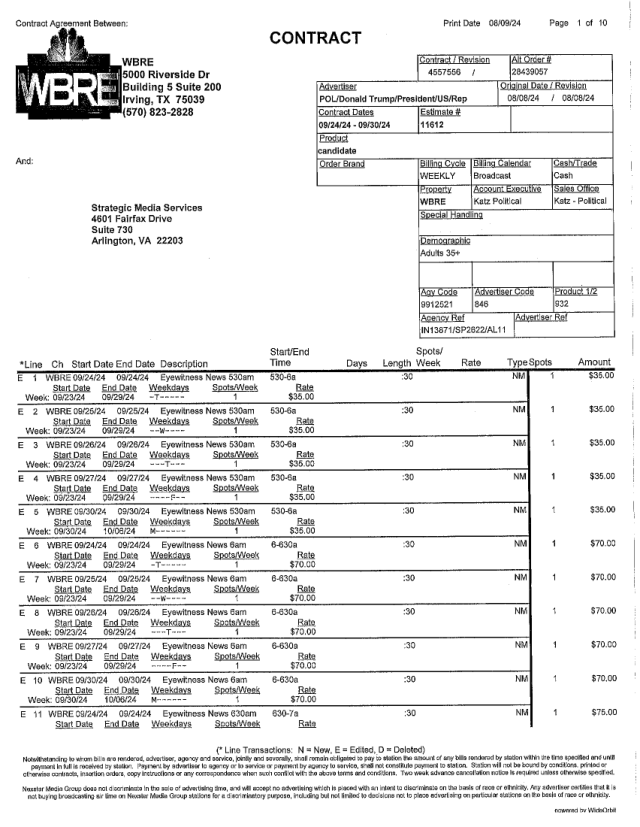

In [47]:
query = f"""
SELECT image_key
FROM `{SOURCE_TABLE}`
WHERE image_key IS NOT NULL
ORDER BY RAND()
LIMIT 1
"""

df = bq_client.query(query).to_dataframe()
page_image = df['image_key'].tolist()[0]
print(page_image)
bucket_name = page_image.split('/')[2]
blob_path   = '/'.join(page_image.split('/')[3:])
print(bucket_name, blob_path)
image = show_image_page(bucket_name, blob_path)
image

This page illustrates why extracting structured data from political campaign invoices with LLMs is non-trivial:

* Dense, multi-section layout – The document combines headers, metadata (invoice number, date, advertiser, agency), and multi-column tables with nested line items. Each region uses different formatting and alignment.

* Irregular tabular structures – Tables include merged cells, grouped rows (e.g., spots grouped by program or station), and embedded totals. Line items often span multiple rows or wrap text, making it difficult for an LLM to segment them reliably.

* Mixed content types – Numeric amounts, percentages, dates, text labels, and codes appear together. Extracting them requires context-sensitive parsing (e.g., distinguishing unit price from gross amount).

* Cross-page dependencies – This is only one page of a multi-page invoice. Totals may be split across pages, and metadata may only appear once at the start, forcing the extraction process to reconcile information across the entire document.

* OCR / layout noise – Depending on PDF quality, text may be fragmented into word-level tokens or misaligned columns, which increases the likelihood of hallucinations when passed directly to an LLM.

# Conclusion

* In this notebook, we established a complete ingestion pipeline for Trump campaign invoices sourced from the FCC database.

* We built functions to download PDFs, extract text and images using PyMuPDF, and upload both raw files and structured outputs into Google Cloud Storage.

* To make the dataset reproducible and publicly accessible, we created a 300-file sample subset and organized it into a dedicated GCS bucket.

* Finally, we prepared a BigQuery table with object references (ObjRefs) to the uploaded PDFs and page images, enabling seamless downstream use of BigQuery’s AI functions for classification and structured data extraction.

This workflow demonstrates how to transform messy, multi-page political ad invoices into a queryable dataset ready for large-scale analysis.